<a href="https://colab.research.google.com/github/makkimaki/python-bayes-intro/blob/main/%E3%81%99%E3%82%89%E3%81%99%E3%82%89%E3%83%99%E3%82%A4%E3%82%BA%E5%86%99%E7%B5%8C_3%E2%88%921.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#業務活用事例


1.   ABテスト
2.   ベイズ回帰モデル
3.   IRT(Item Response Theory)

このノートブックでは1. ABテストを実装していく
- ABテスト： 1920年にフィッシャーによって考案された
    * 目標とする指標値の違いを統計的に調べる→ベイズ推論と相性が良い

## 問題設定
- 鈴木さんと山田さんは自分の担当のWebページを開発しており、従来版(ページA)から修正版(ページB)へ改善作業を行なっている
- それらをランダムに顧客に提示する🆎テストを実施した
- ２人それぞれに改善効果がどれだけあったか？比較をしたい。そしてどちらの改善ページBを採用するかを決めたい

## ポイント
- クリック率だけを見れば、鈴木さんが大きい。しかしデータ数が非常に少なく、偶然の可能性がある
- 山田さんはサンプル数が大きい
- このモヤモヤした感覚を統計的に評価したい

### 確率モデル定義
- 鈴木さんのページAをWebアプリで提示し、目標とするリンクをクリックする確率: `p_s_a = 2/40`
    - 特定の１人ユーザーに注目： クリックするかしないか？はベルヌーイ分布⇨今回は特定の確率に応じた集計値がまとまっているため、二項分布で対応する
    - つまり、ベルヌーイ分布のパラメータ`p`が、`p_s_a`に該当する
- `p_s_b`も同様に設計する

### 問題へのアプローチ
- **ページBがページAより優れていることの判断**

→`p_s_a`と`p_s_b`の差を新しく確率変数と定義し、その分布を見る。分布の正負の状況を見る。

In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.11

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
print(f"{np.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.7.2'
sns.__version__='0.11.0'
np.__version__='1.23.5'


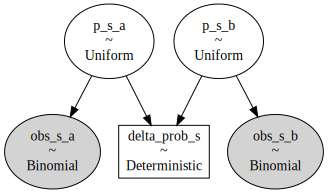

In [3]:
model_s = pm.Model()

with model_s:
    p_s_a = pm.Uniform("p_s_a", lower=0.0, upper=1.0)
    p_s_b = pm.Uniform("p_s_b", lower=0.0, upper=1.0)

    # 二項分布 n: 表示数、observed: ヒット数
    obs_s_a = pm.Binomial("obs_s_a", p=p_s_a, n=40, observed=2)
    obs_s_b = pm.Binomial("obs_s_b", p=p_s_b, n=40, observed=2)

    #　新たな確率変数として、２つの変数の差を定義
    delta_prob_s = pm.Deterministic("delta_prob_s", p_s_b - p_s_a)

g = pm.model_to_graphviz(model_s)
display(g)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


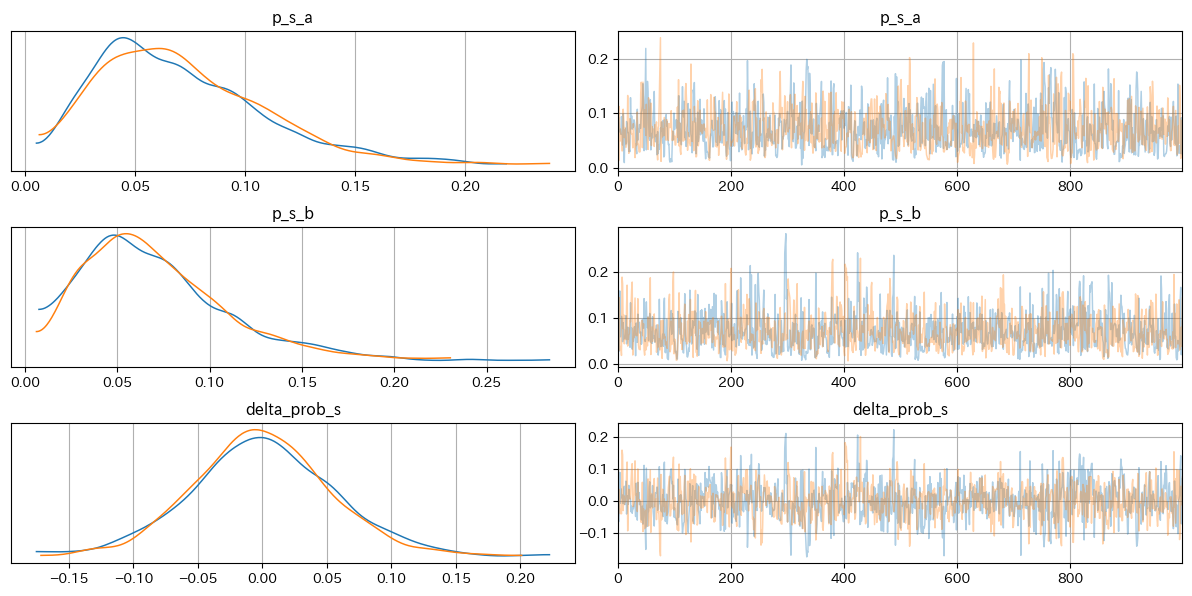

In [4]:
with model_s:
    idata_s = pm.sample(random_seed=42, target_accept=0.99)

az.plot_trace(idata_s, compact=False)
plt.tight_layout()
plt.show()

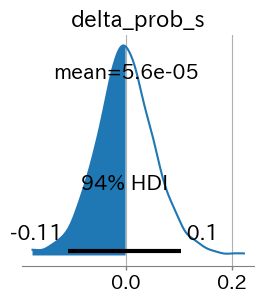

In [5]:
ax = az.plot_posterior(idata_s, var_names=["delta_prob_s"])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0])
plt.show()

In [6]:
idata_s["posterior"]

<xarray.Dataset>
Dimensions:       (chain: 2, draw: 1000)
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    p_s_a         (chain, draw) float64 0.09017 0.09203 ... 0.05019 0.06832
    p_s_b         (chain, draw) float64 0.04379 0.0266 ... 0.03764 0.1435
    delta_prob_s  (chain, draw) float64 -0.04638 -0.06543 ... -0.01255 0.07519
Attributes:
    created_at:                 2024-01-12T01:40:02.368707
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.2
    sampling_time:              22.68740153312683
    tuning_steps:               1000

In [8]:
# ページAの方がクリック率が高い確率を計算する
delta_prob_s = idata_s["posterior"].data_vars["delta_prob_s"]  # delta_oprob_s = idata_s["posterior"]["delta_prob_s"] と同じ
delta_prob_s_values = delta_prob_s.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_s = (delta_prob_s_values < 0).sum()

# 全体サンプル数
n_s = len(delta_prob_s_values)

# 比率計算
n1_rate_s = n1_s/n_s

print(f"鈴木さんのケース　ページAの方がクリック率が高い確率: {n1_rate_s * 100:.02f}%") # ←書籍中とは異なる値になった。書籍中: 29.45%

鈴木さんのケース　ページAの方がクリック率が高い確率: 50.95%


### 山田さんの場合は？
これまでに鈴木さんの🆎テストの効果検証が終わった。山田さんについても同様に実験する。

In [10]:
model_y = pm.Model()

with model_y:
    p_y_a = pm.Uniform("p_s_a", lower=0.0, upper=1.0)
    p_y_b = pm.Uniform("p_s_b", lower=0.0, upper=1.0)

    # 事前分布に対して、観測値を組み込む分布が常に必要なことを念頭に。今回はクリック数をobsとしてとる
    obs_y_a = pm.Binomial("obs_y_a", p=p_y_a, n=1200, observed=60)
    obs_y_b = pm.Binomial("obs_y_b", p=p_y_b, n=1600, observed=110)

    delta_prob_y = pm.Deterministic("delta_prob_y", p_y_b - p_y_a)

with model_y:
    idata_y = pm.sample(random_seed=42, target_accept=0.99)

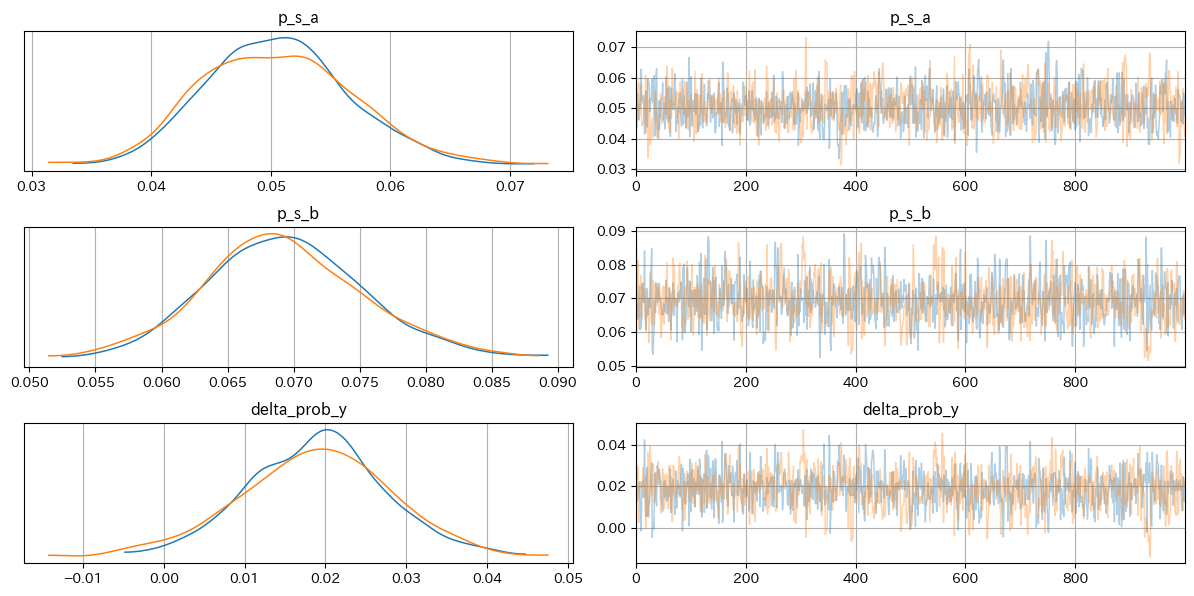

In [11]:
az.plot_trace(idata_y, compact=False)
plt.tight_layout()
plt.show()

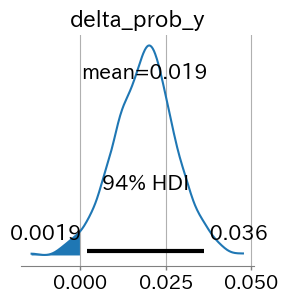

In [12]:
ax = az.plot_posterior(idata_y, var_names=["delta_prob_y"])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0])
plt.show()